In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
news_sentiment = 'nela_preprocessed_sentiment.csv'
news_sentiment = pd.read_csv(news_sentiment, low_memory=False)

news_iptc = 'nela_preprocessed_iptc.csv'
news_iptc = pd.read_csv(news_iptc, low_memory=False)

# Merge the two DataFrames on the 'id' column
news_df = news_sentiment.merge(news_iptc[['id', 'IPTC_topic', 'IPTC_topic_score']], on='id', how='left')

In [66]:
# Create source_order based on total article count per source (descending)
source_order = news_df["source"].value_counts().index.tolist()
news_df["source"].value_counts()

source
cnn                4720
breitbart          4012
thenewyorktimes    3024
usatoday           2811
washingtonpost     1546
foxnews            1285
theguardian        1219
bbc                 838
npr                 798
yahoonews           738
buzzfeed            634
Name: count, dtype: int64

In [67]:
n_days = 95 

def mention_mask(df, col):
    return ~df[col].isna()

summary = []
for source, group in news_df.groupby('source'):
    total = len(group)
    biden = mention_mask(group, 'biden_sentiment_score').sum()
    trump = mention_mask(group, 'trump_sentiment_score').sum()
    both = (mention_mask(group, 'biden_sentiment_score') & mention_mask(group, 'trump_sentiment_score')).sum()
    daily_avg = total / n_days if n_days > 0 else np.nan
    summary.append({
        'Source': source,
        'Total Count': total,
        'Biden%': round(biden / total * 100, 2) if total else 0,
        'Trump%': round(trump / total * 100, 2) if total else 0,
        'Both%': round(both / total * 100, 2) if total else 0,
        'Daily Avg.': round(daily_avg, 2)
    })

summary_df = pd.DataFrame(summary).sort_values('Total Count', ascending=False).reset_index(drop=True)

In [68]:
summary_df 

,Source,Total Count,Biden%,Trump%,Both%,Daily Avg.
0,cnn,4720,50.64,94.41,45.04,49.68
1,breitbart,4012,56.23,88.93,45.16,42.23
2,thenewyorktimes,3024,44.97,93.25,38.23,31.83
3,usatoday,2811,58.98,93.60,52.58,29.59
4,washingtonpost,1546,57.96,96.77,54.72,16.27
5,foxnews,1285,62.57,93.39,55.95,13.53
6,theguardian,1219,63.49,96.64,60.13,12.83
7,bbc,838,50.36,84.49,34.84,8.82
8,npr,798,42.98,94.24,37.22,8.40
9,yahoonews,738,69.38,97.70,67.07,7.77


In [69]:
topic_cols = ['healthcare', 'economy', 'social_issues']

# Add a column to indicate "others" (all topics are 0)
def is_other(row):
    return int((row[topic_cols].sum() == 0))

# Add a new column 'others' to the DataFrame
news_df['others'] = news_df.apply(is_other, axis=1)
print(news_df[['healthcare', 'economy', 'social_issues', 'others']].sum())

healthcare       10397
economy           3837
social_issues     3674
others            8438
dtype: int64


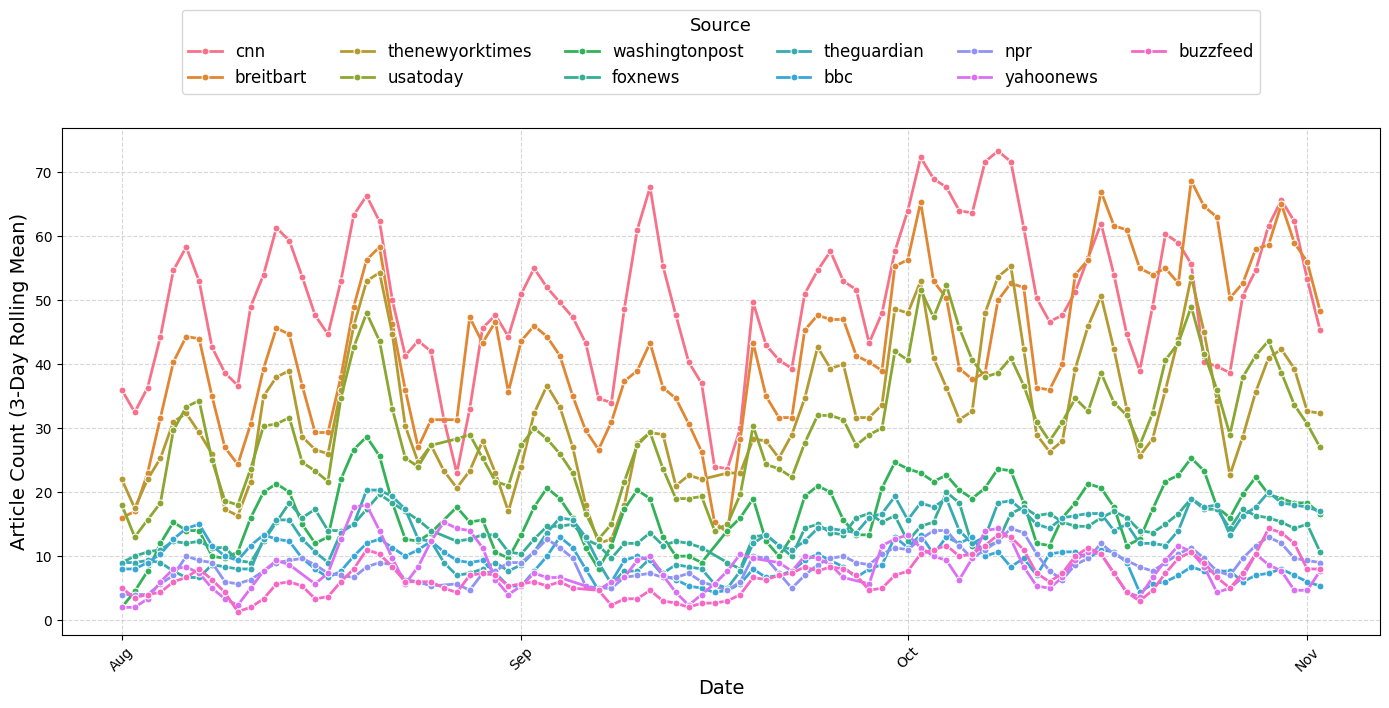

In [70]:
# 2. Daily article count per source (with 3-day rolling mean for clarity)
# Ensure datetime
news_df['date'] = pd.to_datetime(news_df['date'])
# Calculate 3-day rolling mean for each source
daily_counts = news_df.groupby(['date', 'source']).size().reset_index(name='count')
daily_counts['rolling_mean'] = daily_counts.groupby('source')['count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=daily_counts,
    x='date',
    y='rolling_mean',
    hue='source',
    hue_order= source_order,
    marker='o',
    linewidth=2,
    markersize=5
)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Article Count (3-Day Rolling Mean)', fontsize=14)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(
    title='Source',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=6,  # Adjust number of columns as needed
    fontsize=12,
    title_fontsize=13
)
plt.show()

In [71]:
# Group by date and compute daily mean sentiment for each candidate
daily_sent = news_df.groupby('date')[['biden_sentiment_score', 'trump_sentiment_score', 
                                      'biden_hf_sentiment_score', 'trump_hf_sentiment_score']].mean().reset_index()

# Compute 3-day rolling mean
daily_sent['biden_tb_rolling'] = daily_sent['biden_sentiment_score'].rolling(window=3, min_periods=1).mean()
daily_sent['trump_tb_rolling'] = daily_sent['trump_sentiment_score'].rolling(window=3, min_periods=1).mean()
daily_sent['biden_hf_rolling'] = daily_sent['biden_hf_sentiment_score'].rolling(window=3, min_periods=1).mean()
daily_sent['trump_hf_rolling'] = daily_sent['trump_hf_sentiment_score'].rolling(window=3, min_periods=1).mean()

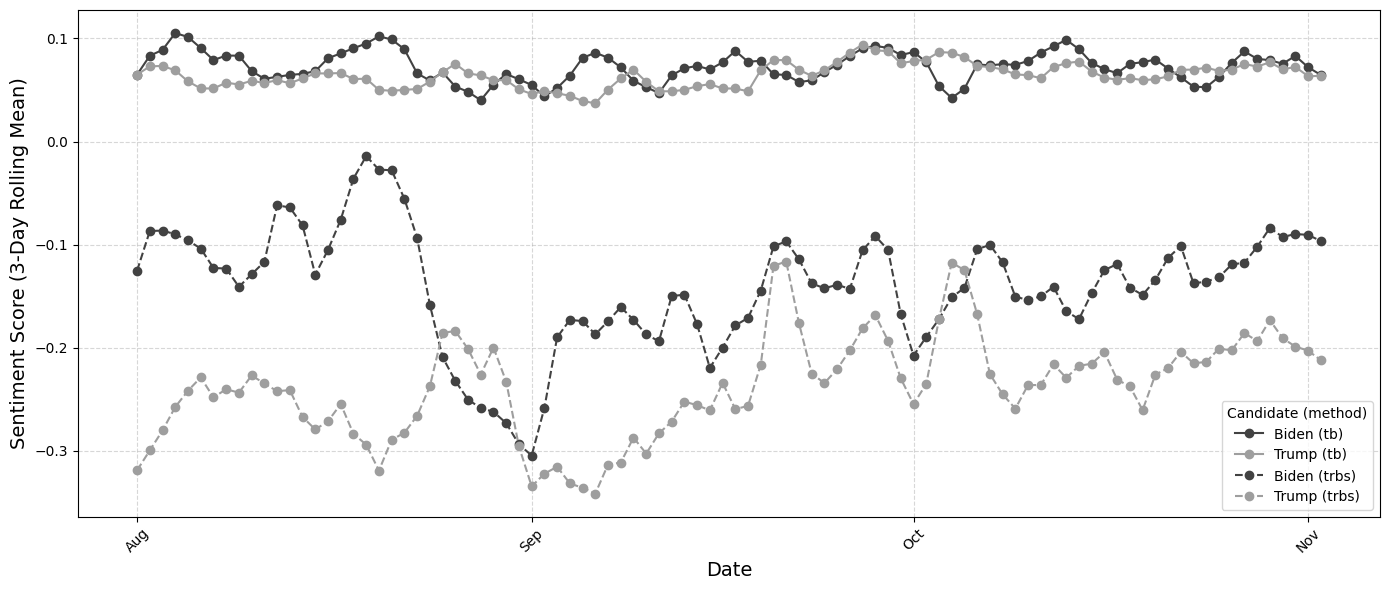

In [72]:

# Your existing plotting code
plt.figure(figsize=(14, 6))
plt.plot(daily_sent['date'], daily_sent['biden_tb_rolling'], label='Biden (tb)', marker='o', color='#424242', linestyle='-')
plt.plot(daily_sent['date'], daily_sent['trump_tb_rolling'], label='Trump (tb)', marker='o', color='#9e9e9e', linestyle='-')
plt.plot(daily_sent['date'], daily_sent['biden_hf_rolling'], label='Biden (trbs)', marker='o', color='#424242', linestyle='--')
plt.plot(daily_sent['date'], daily_sent['trump_hf_rolling'], label='Trump (trbs)', marker='o', color='#9e9e9e', linestyle='--')

# Set x-axis ticks to only the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score (3-Day Rolling Mean)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Candidate (method)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


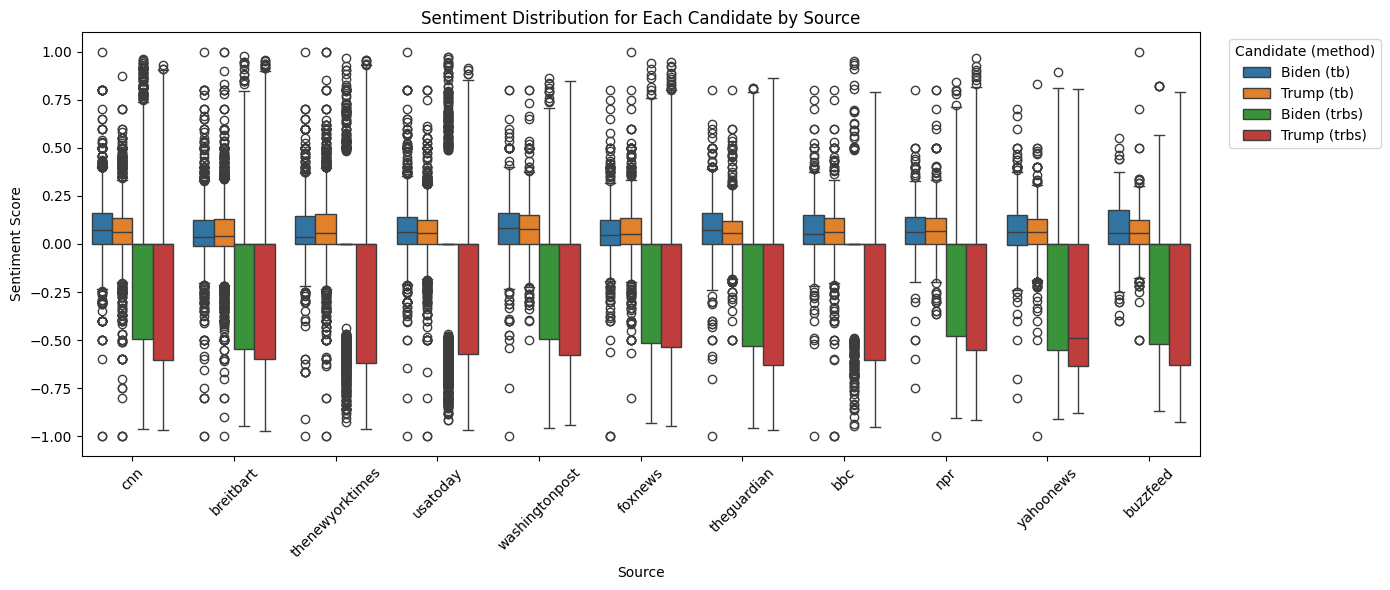

In [73]:
# Melt the DataFrame to long format for easier plotting
sentiment_long = news_df.melt(
    id_vars=['source'],
    value_vars=['biden_sentiment_score', 'trump_sentiment_score', 'biden_hf_sentiment_score', 'trump_hf_sentiment_score'],
    var_name='candidate_method',
    value_name='sentiment'
)

# Map to readable labels
sentiment_long['candidate'] = sentiment_long['candidate_method'].map({
    'biden_sentiment_score': 'Biden (tb)',
    'trump_sentiment_score': 'Trump (tb)',
    'biden_hf_sentiment_score': 'Biden (trbs)',
    'trump_hf_sentiment_score': 'Trump (trbs)'
})

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=sentiment_long,
    x='source',
    y='sentiment',
    hue='candidate',
    order=source_order
)
plt.title('Sentiment Distribution for Each Candidate by Source')
plt.ylabel('Sentiment Score')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.legend(title='Candidate (method)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

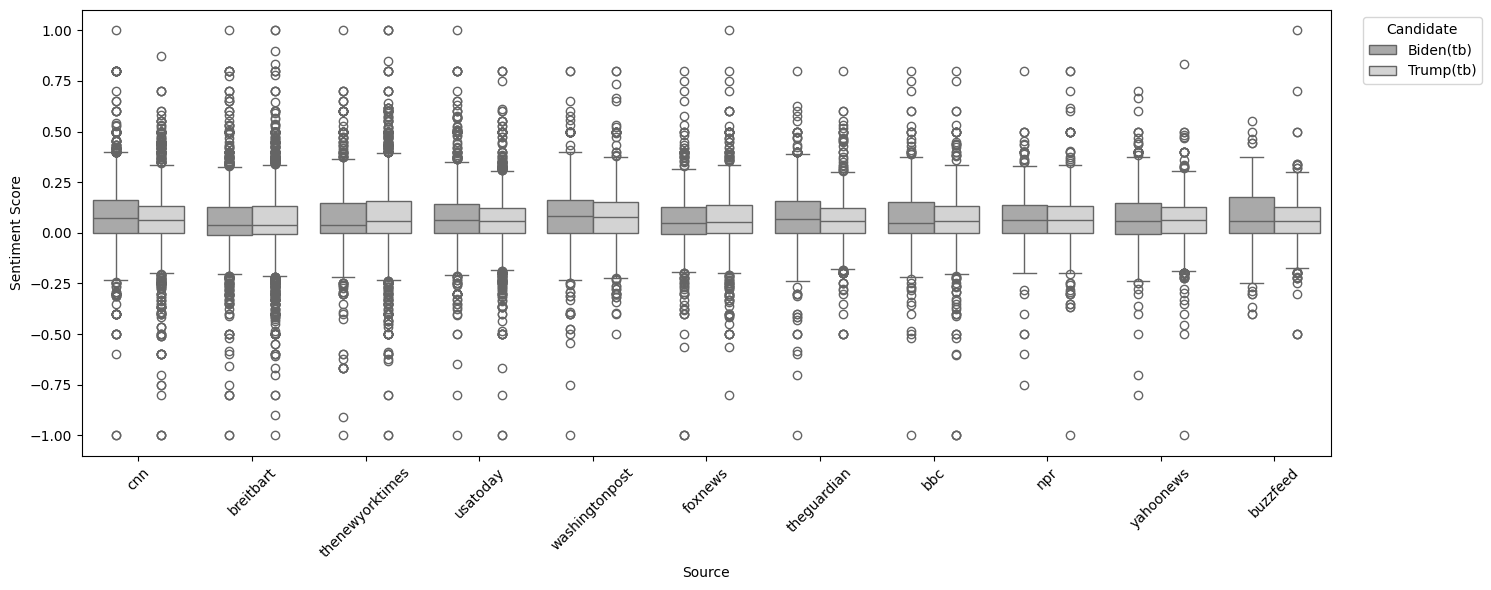

In [74]:
# Melt to long format (combine both methods for each candidate)
# Sentiment Distribution for Each Candidate by Source
sentiment_long = news_df.melt(
    id_vars=['source'],
    value_vars=['biden_sentiment_score', 'trump_sentiment_score'],
    var_name='candidate_method',
    value_name='sentiment'
)
sentiment_long['candidate'] = sentiment_long['candidate_method'].map({
    'biden_sentiment_score': 'Biden(tb)',
    'trump_sentiment_score': 'Trump(tb)'
})

plt.figure(figsize=(15, 6))
sns.boxplot(
    data=sentiment_long,
    x='source',
    y='sentiment',
    hue='candidate',
    order=source_order,
    palette={"Biden(tb)": "darkgrey", "Trump(tb)": "lightgrey"}
)
plt.ylabel('Sentiment Score')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.legend(title='Candidate', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

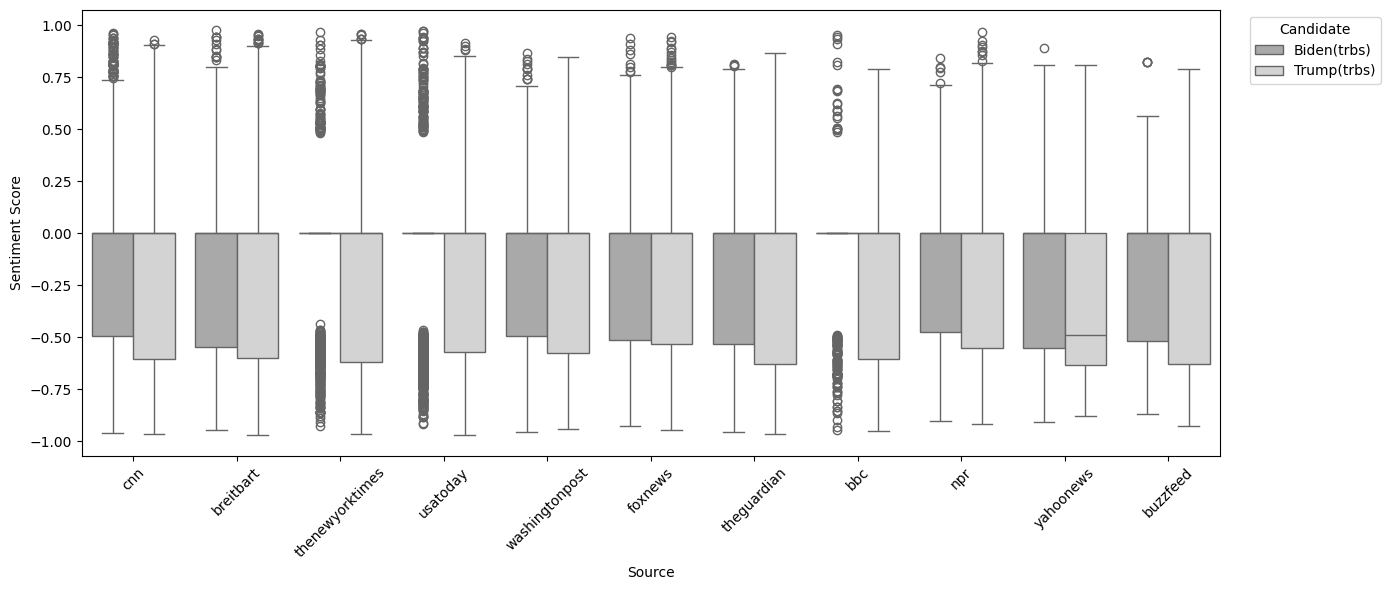

In [75]:
# Melt to long format (combine both methods for each candidate)
sentiment_long = news_df.melt(
    id_vars=['source'],
    value_vars=['biden_hf_sentiment_score', 'trump_hf_sentiment_score'],
    var_name='candidate_method',
    value_name='sentiment'
)
sentiment_long['candidate'] = sentiment_long['candidate_method'].map({
    'biden_hf_sentiment_score': 'Biden(trbs)',
    'trump_hf_sentiment_score': 'Trump(trbs)'
})

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=sentiment_long,
    x='source',
    y='sentiment',
    hue='candidate',
    order=source_order,
    palette={"Biden(trbs)": "darkgrey", "Trump(trbs)": "lightgrey"}
)
plt.ylabel('Sentiment Score')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.legend(title='Candidate', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [76]:
# Define categorization function
def categorize_sentiment(score):
    if pd.isna(score):
        return None  # Return None to filter later
    elif score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization
news_df['biden_sentiment_cat'] = news_df['biden_sentiment_score'].apply(categorize_sentiment)
news_df['trump_sentiment_cat'] = news_df['trump_sentiment_score'].apply(categorize_sentiment)

# Reshape into long format
biden_sentiment_long = news_df[['source', 'biden_sentiment_cat']].rename(columns={'biden_sentiment_cat': 'sentiment'})
biden_sentiment_long['candidate'] = 'Biden'

trump_sentiment_long = news_df[['source', 'trump_sentiment_cat']].rename(columns={'trump_sentiment_cat': 'sentiment'})
trump_sentiment_long['candidate'] = 'Trump'

# Combine and drop rows with None (i.e., missing sentiment)
sentiment_long = pd.concat([biden_sentiment_long, trump_sentiment_long])
sentiment_long = sentiment_long.dropna(subset=['sentiment'])

# Count and normalize within each (source, candidate)
sentiment_counts = pd.crosstab(
    [sentiment_long['source'], sentiment_long['candidate']],
    sentiment_long['sentiment']
)

# Calculate percentages
sentiment_percent = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_percent = sentiment_percent.round(2)

sentiment_percent

sentiment                  Negative  Neutral  Positive
source          candidate                             
bbc             Biden          3.55    78.44     18.01
                Trump          4.52    82.77     12.71
breitbart       Biden          2.97    84.40     12.63
                Trump          3.98    82.20     13.82
buzzfeed        Biden          3.17    80.95     15.87
                Trump          1.48    87.17     11.35
cnn             Biden          2.01    81.26     16.74
                Trump          2.11    86.29     11.60
foxnews         Biden          3.61    85.32     11.07
                Trump          3.83    82.92     13.25
npr             Biden          2.04    85.71     12.24
                Trump          1.86    88.56      9.57
theguardian     Biden          2.84    81.27     15.89
                Trump          1.02    89.64      9.34
thenewyorktimes Biden          2.21    81.10     16.69
                Trump          3.90    79.18     16.91
usatoday        Biden          2.29    83.47     14.23
                Trump          2.17    87.84     10.00
washingtonpost  Biden          2.34    81.36     16.29
                Trump          1.40    86.63     11.97
yahoonews       Biden          2.73    80.08     17.19
                Trump          1.94    89.60      8.46

In [77]:
# Define categorization function for Hugging Face scores
def categorize_hf_sentiment(score):
    if pd.isna(score):
        return None
    elif score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization
news_df['biden_hf_sentiment_cat'] = news_df['biden_hf_sentiment_score'].apply(categorize_hf_sentiment)
news_df['trump_hf_sentiment_cat'] = news_df['trump_hf_sentiment_score'].apply(categorize_hf_sentiment)

# Reshape into long format
biden_hf_long = news_df[['source', 'biden_hf_sentiment_cat']].rename(columns={'biden_hf_sentiment_cat': 'sentiment'})
biden_hf_long['candidate'] = 'Biden'

trump_hf_long = news_df[['source', 'trump_hf_sentiment_cat']].rename(columns={'trump_hf_sentiment_cat': 'sentiment'})
trump_hf_long['candidate'] = 'Trump'

# Combine and drop rows with None
hf_sentiment_long = pd.concat([biden_hf_long, trump_hf_long])
hf_sentiment_long = hf_sentiment_long.dropna(subset=['sentiment'])

# Count and normalize within each (source, candidate)
hf_sentiment_counts = pd.crosstab(
    [hf_sentiment_long['source'], hf_sentiment_long['candidate']],
    hf_sentiment_long['sentiment']
)

# Calculate percentages
hf_sentiment_percent = hf_sentiment_counts.div(hf_sentiment_counts.sum(axis=1), axis=0) * 100
hf_sentiment_percent = hf_sentiment_percent.round(2)

hf_sentiment_percent

sentiment                  Negative  Neutral  Positive
source          candidate                             
bbc             Biden         23.93    70.85      5.21
                Trump         42.80    53.67      3.53
breitbart       Biden         33.07    62.68      4.26
                Trump         39.52    53.25      7.23
buzzfeed        Biden         32.38    65.71      1.90
                Trump         45.89    51.48      2.63
cnn             Biden         26.23    65.52      8.24
                Trump         41.00    54.98      4.02
foxnews         Biden         27.99    68.03      3.98
                Trump         31.25    62.50      6.25
npr             Biden         25.66    66.47      7.87
                Trump         34.18    59.84      5.98
theguardian     Biden         31.52    63.31      5.17
                Trump         47.96    49.32      2.72
thenewyorktimes Biden         19.41    73.38      7.21
                Trump         43.30    52.27      4.43
usatoday        Biden         24.79    68.64      6.57
                Trump         36.87    58.84      4.29
washingtonpost  Biden         26.67    68.53      4.80
                Trump         40.11    56.82      3.07
yahoonews       Biden         37.11    59.57      3.32
                Trump         52.43    45.49      2.08

In [78]:
# Topic distribution by candidate and by source
topic_cols = ['healthcare', 'economy', 'social_issues', 'others']

# Create a long DataFrame for candidate-topic analysis
biden_topics = news_df.loc[~news_df['biden_sentiment_score'].isna(), topic_cols].copy()
biden_topics['candidate'] = 'Biden'
trump_topics = news_df.loc[~news_df['trump_sentiment_score'].isna(), topic_cols].copy()
trump_topics['candidate'] = 'Trump'
candidate_topics_long = pd.concat([biden_topics, trump_topics])

# By candidate
candidate_topic = candidate_topics_long.groupby('candidate')[topic_cols].sum()
candidate_topic['total'] = candidate_topic.sum(axis=1)
for col in topic_cols:
    candidate_topic[col + '_pct'] = (candidate_topic[col] / candidate_topic['total'] * 100).round(2)
candidate_topic = candidate_topic[[col + '_pct' for col in topic_cols]]

# By source (for each candidate)
biden_by_source = news_df.loc[~news_df['biden_sentiment_score'].isna()].groupby('source')[topic_cols].sum()
biden_by_source['total'] = biden_by_source.sum(axis=1)
for col in topic_cols:
    biden_by_source[col + '_pct'] = (biden_by_source[col] / biden_by_source['total'] * 100).round(2)
biden_by_source = biden_by_source[[col + '_pct' for col in topic_cols]]

trump_by_source = news_df.loc[~news_df['trump_sentiment_score'].isna()].groupby('source')[topic_cols].sum()
trump_by_source['total'] = trump_by_source.sum(axis=1)
for col in topic_cols:
    trump_by_source[col + '_pct'] = (trump_by_source[col] / trump_by_source['total'] * 100).round(2)
trump_by_source = trump_by_source[[col + '_pct' for col in topic_cols]]

In [79]:
candidate_topic

,healthcare_pct,economy_pct,social_issues_pct,others_pct
candidate,,,,
Biden,39.15,15.50,15.42,29.93
Trump,40.39,14.91,14.04,30.66


In [80]:
biden_by_source

,healthcare_pct,economy_pct,social_issues_pct,others_pct
source,,,,
bbc,39.88,9.63,17.88,32.61
breitbart,20.95,16.41,13.25,49.39
buzzfeed,51.66,11.85,17.30,19.19
cnn,43.60,16.08,14.26,26.06
foxnews,34.53,13.18,12.53,39.76
npr,45.96,15.70,18.61,19.73
theguardian,47.48,15.49,20.44,16.59
thenewyorktimes,32.49,15.84,15.03,36.64
usatoday,47.21,18.10,16.45,18.23


In [81]:
trump_by_source

,healthcare_pct,economy_pct,social_issues_pct,others_pct
source,,,,
bbc,38.02,10.86,17.83,33.29
breitbart,23.99,14.77,12.72,48.52
buzzfeed,50.52,11.95,18.83,18.70
cnn,44.24,14.83,12.80,28.14
foxnews,35.99,12.07,12.07,39.87
npr,48.75,13.57,14.88,22.80
theguardian,46.43,15.05,19.17,19.35
thenewyorktimes,34.29,14.72,12.12,38.87
usatoday,48.62,18.68,15.31,17.40


In [82]:
news_df["IPTC_topic"].value_counts()

IPTC_topic
politics                                     17244
health                                        1090
crime, law and justice                         862
conflict, war and peace                        624
economy, business and finance                  373
human interest                                 278
arts, culture, entertainment and media         252
society                                        200
sport                                          183
disaster, accident and emergency incident      175
education                                      115
labour                                         109
environment                                     51
lifestyle and leisure                           26
science and technology                          18
religion                                        16
weather                                          9
Name: count, dtype: int64

In [83]:
# Table: IPTC topic distribution by candidate

# For Biden: articles with a biden_sentiment_score (not NaN)
biden_iptc = news_df.loc[~news_df['biden_sentiment_score'].isna(), 'IPTC_topic'].value_counts().to_frame(name='Biden_count')

# For Trump: articles with a trump_sentiment_score (not NaN)
trump_iptc = news_df.loc[~news_df['trump_sentiment_score'].isna(), 'IPTC_topic'].value_counts().to_frame(name='Trump_count')

# Combine into one table
iptc_by_candidate = biden_iptc.join(trump_iptc, how='outer').fillna(0).astype(int)

# Optionally, add percentage columns
iptc_by_candidate['Biden_pct'] = (iptc_by_candidate['Biden_count'] / iptc_by_candidate['Biden_count'].sum() * 100).round(2)
iptc_by_candidate['Trump_pct'] = (iptc_by_candidate['Trump_count'] / iptc_by_candidate['Trump_count'].sum() * 100).round(2)
iptc_by_candidate[['Biden_pct', 'Trump_pct']]  # Display only percentage columns                           

,Biden_pct,Trump_pct
IPTC_topic,,
"arts, culture, entertainment and media",0.84,1.02
"conflict, war and peace",1.67,2.89
"crime, law and justice",1.76,3.84
"disaster, accident and emergency incident",0.32,0.82
"economy, business and finance",0.85,1.70
education,0.29,0.50
environment,0.20,0.22
health,1.52,5.23
human interest,0.90,1.13


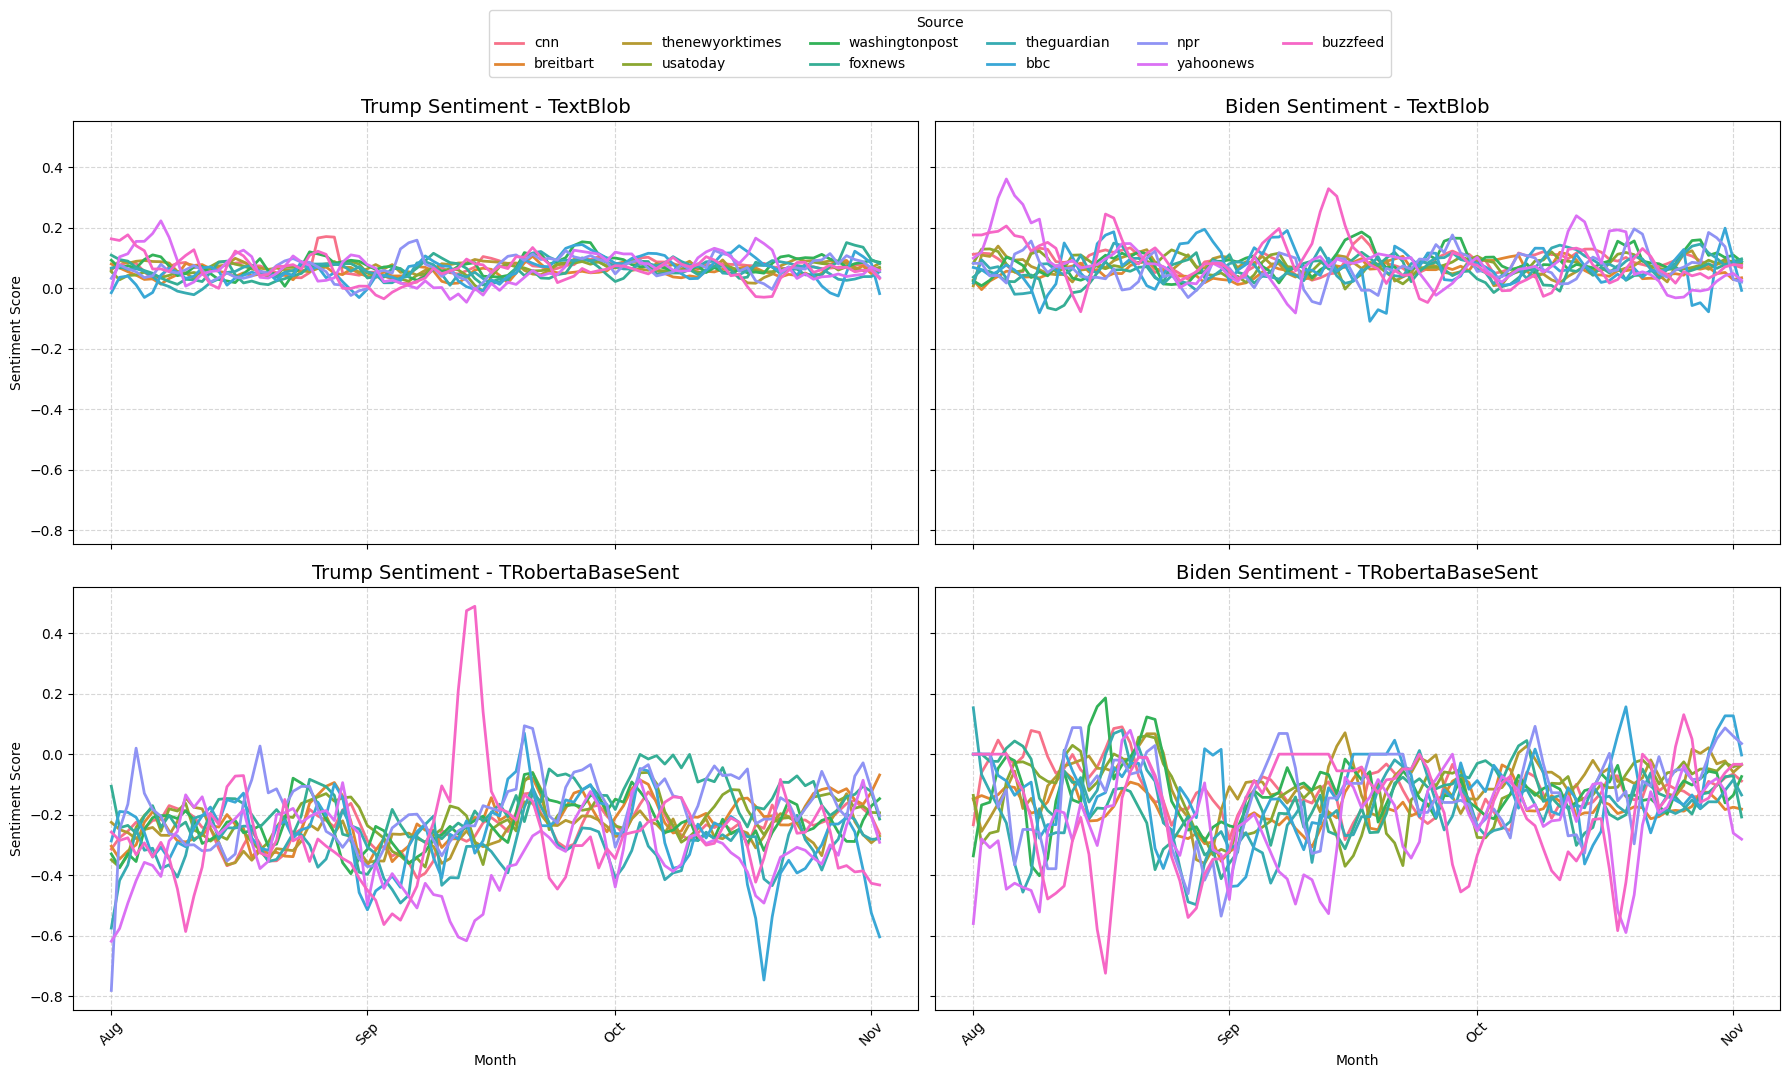

In [84]:
# 3-Day Rolling Sentiment Scores by Candidate and Method
# Set up sentiment methods and candidates
sentiment_methods = {
    "TextBlob": ("trump_sentiment_score", "biden_sentiment_score"),
    "TRobertaBaseSent": ("trump_hf_sentiment_score", "biden_hf_sentiment_score")
}

fig, axes = plt.subplots(2, 2, figsize=(21, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (method, (trump_col, biden_col)) in enumerate(sentiment_methods.items()):
    for j, (candidate, col) in enumerate([('Trump', trump_col), ('Biden', biden_col)]):
        # Compute daily mean sentiment
        daily_sent = (
            news_df.groupby(['date', 'source'])[col]
            .mean()
            .reset_index()
        )

        # 3-day rolling average
        daily_sent = daily_sent.sort_values(['source', 'date'])
        daily_sent['rolling_mean'] = (
            daily_sent.groupby('source')[col]
            .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
        )

        # Plot
        ax = axes[idx * 2 + j]
        sns.lineplot(
            data=daily_sent,
            x='date',
            y='rolling_mean',
            hue='source',
            hue_order=source_order,
            linewidth=2,
            ax=ax
        )
        ax.set_title(f'{candidate} Sentiment - {method}', fontsize=14)
        ax.set_xlabel('Month')
        ax.set_ylabel('Sentiment Score')
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend().remove()  # Hide legend for now

# Adjust layout and add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Source',bbox_to_anchor=(0.45, 1.08), ncol=6, loc='upper center')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

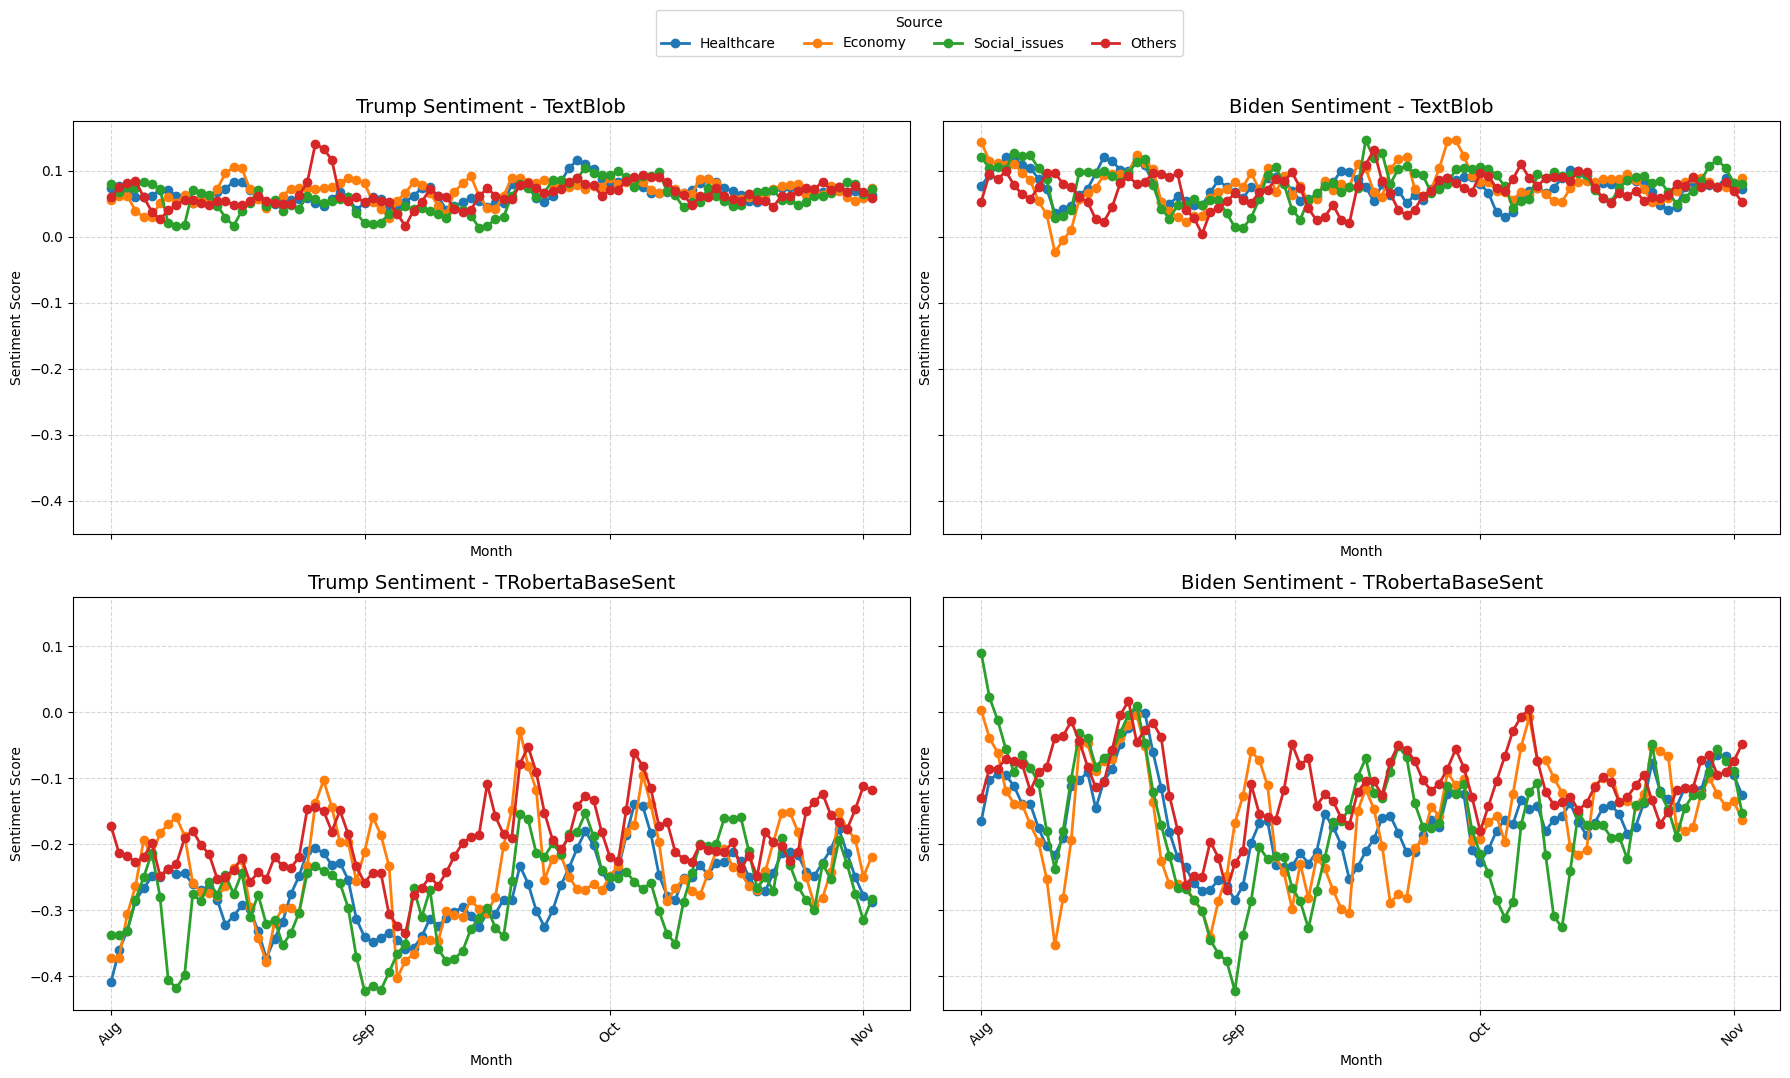

In [98]:
# 3-Day Rolling Sentiment Scores by Candidate and Method, grouped by topic_cols (not source)

sentiment_methods = {
    "TextBlob": ("trump_sentiment_score", "biden_sentiment_score"),
    "TRobertaBaseSent": ("trump_hf_sentiment_score", "biden_hf_sentiment_score")
}
topic_cols = ['healthcare', 'economy', 'social_issues', 'others']

fig, axes = plt.subplots(2, 2, figsize=(21, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (method, (trump_col, biden_col)) in enumerate(sentiment_methods.items()):
    for j, (candidate, col) in enumerate([('Trump', trump_col), ('Biden', biden_col)]):
        ax = axes[idx * 2 + j]
        for topic in topic_cols:
            # Filter articles with this topic
            topic_mask = news_df[topic] == 1
            df_topic = news_df.loc[topic_mask, ['date', col]].copy()
            df_topic = df_topic.dropna(subset=[col])
            # Group by date, compute daily mean sentiment
            daily_sent = df_topic.groupby('date')[col].mean().reset_index()
            # 3-day rolling average
            daily_sent = daily_sent.sort_values('date')
            daily_sent['rolling_mean'] = daily_sent[col].rolling(window=3, min_periods=1).mean()
            # Plot
            ax.plot(
                daily_sent['date'],
                daily_sent['rolling_mean'],
                label=topic.capitalize(),
                linewidth=2,
                marker='o'
            )
        ax.set_title(f'{candidate} Sentiment - {method}', fontsize=14)
        ax.set_xlabel('Month')
        ax.set_ylabel('Sentiment Score')
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend().remove()

# Adjust layout and add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Source',bbox_to_anchor=(0.44, 1.08), ncol=6, loc='upper center')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

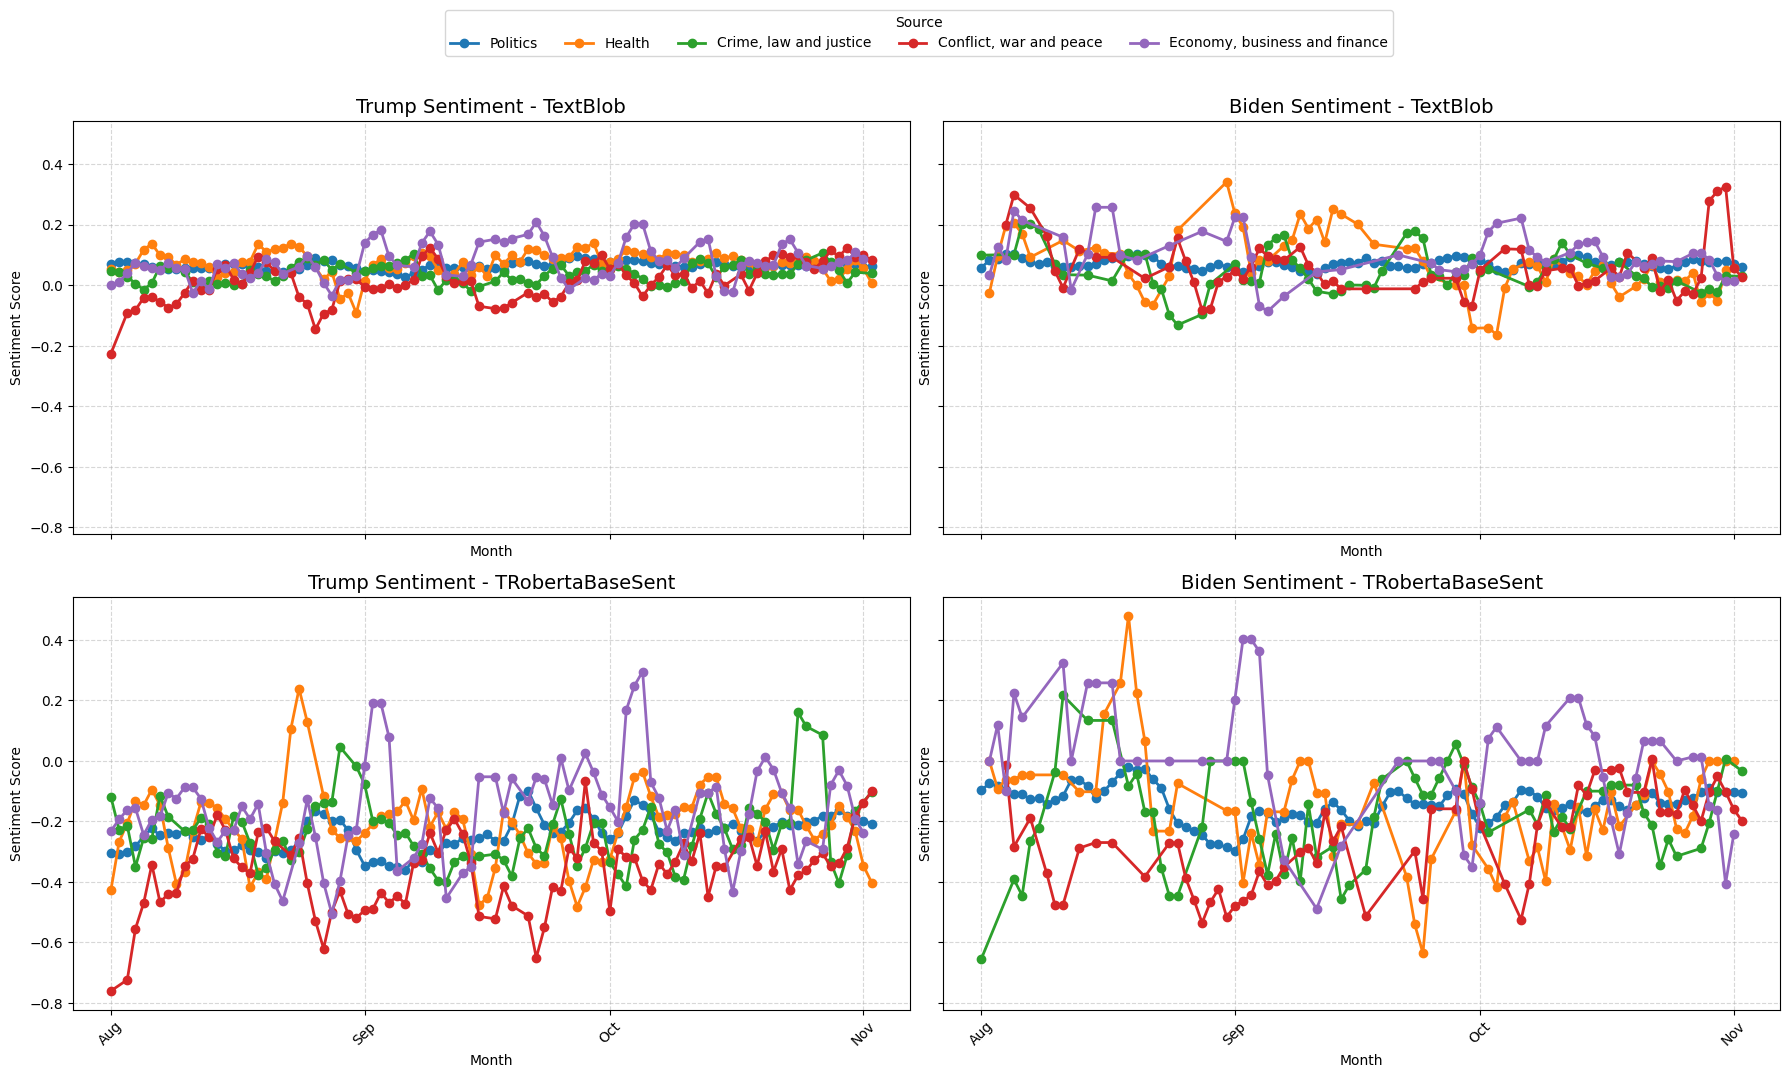

In [100]:
# 3-Day Rolling Sentiment Scores by Candidate and Method, grouped by top 5 IPTC_topic

sentiment_methods = {
    "TextBlob": ("trump_sentiment_score", "biden_sentiment_score"),
    "TRobertaBaseSent": ("trump_hf_sentiment_score", "biden_hf_sentiment_score")
}

# Get top 5 IPTC topics by count
top_5_iptc = news_df['IPTC_topic'].value_counts().head(5).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(21, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (method, (trump_col, biden_col)) in enumerate(sentiment_methods.items()):
    for j, (candidate, col) in enumerate([('Trump', trump_col), ('Biden', biden_col)]):
        ax = axes[idx * 2 + j]
        for topic in top_5_iptc:
            # Filter articles with this IPTC topic
            topic_mask = news_df['IPTC_topic'] == topic
            df_topic = news_df.loc[topic_mask, ['date', col]].copy()
            df_topic = df_topic.dropna(subset=[col])
            # Group by date, compute daily mean sentiment
            daily_sent = df_topic.groupby('date')[col].mean().reset_index()
            # 3-day rolling average
            daily_sent = daily_sent.sort_values('date')
            daily_sent['rolling_mean'] = daily_sent[col].rolling(window=3, min_periods=1).mean()
            # Plot
            ax.plot(
                daily_sent['date'],
                daily_sent['rolling_mean'],
                label=str(topic).capitalize(),
                linewidth=2,
                marker='o'
            )
        ax.set_title(f'{candidate} Sentiment - {method}', fontsize=14)
        ax.set_xlabel('Month')
        ax.set_ylabel('Sentiment Score')
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend().remove()


# Adjust layout and add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Source',bbox_to_anchor=(0.44, 1.08), ncol=6, loc='upper center')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()